# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import re
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Import The Dataset

The data processed contains the the training data, validation data, and test data (with unmasked and masked label) that has been preprocessed. However, later on, we will further preprocess the code to increase the accuracy.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv("drive/MyDrive/sentiment-prosa/train_preprocess.tsv", sep='\t', header=None)
df_valid = pd.read_csv("drive/MyDrive/sentiment-prosa/valid_preprocess.tsv", sep='\t', header=None)
df_test_unmasked = pd.read_csv("drive/MyDrive/sentiment-prosa/test_preprocess.tsv", sep='\t', header=None)
df_test_masked = pd.read_csv("drive/MyDrive/sentiment-prosa/test_preprocess_masked_label.tsv", sep='\t', header=None)

Open the vocabulary document

In [ ]:
with open('drive/MyDrive/sentiment-prosa/vocab_uncased.txt', 'r') as f:
    vocab = f.read().splitlines()

In [ ]:
df_train.columns = ["text", "emotion"]
df_valid.columns = ["text", "emotion"]
df_test_unmasked.columns = ["text", "emotion"]
df_test_masked.columns = ["text", "emotion"]

df_train.head(10)

,text,emotion
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


# Pre-processing

## Remove punctuation and numbers

In [ ]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', text)

In [ ]:
df_train['text'] = df_train['text'].apply(remove_punctuation)
df_valid['text'] = df_valid['text'].apply(remove_punctuation)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(remove_punctuation)
df_test_masked['text'] = df_test_masked['text'].apply(remove_punctuation)

vocab_filtered = []

for word in vocab:
  word_filtered = remove_punctuation(word)
  vocab_filtered.append(word_filtered)



In [ ]:
df_train.head(10)

,text,emotion
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh jadi mahasiswa jangan sombong dong kas...,negative
5,makanan beragam harga makanan di food stall ...,positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,tempat unik bagus buat foto makanan enak ...,positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


In [ ]:
df_test_unmasked.head(10)

,text,emotion
0,kemarin gue datang ke tempat makan baru yang a...,negative
1,kayak nya sih gue tidak akan mau balik lagi ke...,negative
2,kalau dipikir pikir sebenarnya tidak ada yan...,negative
3,ini pertama kalinya gua ke bank buat ngurusin ...,negative
4,waktu sampai dengan gue pernah disuruh ibu lat...,negative
5,pelayanan di hotel salak bogor tidak sebagus y...,negative
6,ada apa dengan young lex kenapa dia harus me...,negative
7,gue pesimis sama manusia terutama dalam ngur...,negative
8,saya kecewa karena pengeditan biodata penumpan...,negative
9,saya hari ini melakukan pemesanan dan tiket sa...,negative


# Exploratory Data Analysis

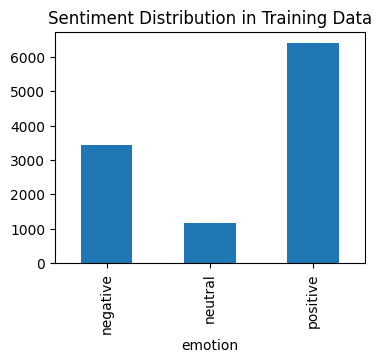

,text
emotion,
negative,3436
neutral,1148
positive,6416


In [ ]:
fig = plt.figure(figsize=(4,3))
df_train.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Sentiment Distribution in Training Data")
plt.show()
df_train.groupby('emotion').text.count()

In [ ]:
# Encoding emotions
emotion_encoding = {'negative': 0, 'neutral': 1, 'positive': 2}

df_train['emotion'] = df_train['emotion'].replace(emotion_encoding)
df_valid['emotion'] = df_valid['emotion'].replace(emotion_encoding)
df_test_unmasked['emotion'] = df_test_unmasked['emotion'].replace(emotion_encoding)
df_test_masked['emotion'] = df_test_masked['emotion'].replace(emotion_encoding)

# Experiment 1: Linear Kernel

## Training

In [ ]:
# Create a bag of words from the vocab_uncased.txt
cleaned_vocab = [string.strip() for string in vocab_filtered if string.strip()]
cleaned_vocab = list(dict.fromkeys(cleaned_vocab))
vectorizer = CountVectorizer(vocabulary=cleaned_vocab)

# Extract training, validation, and test data into each array and transform using vocabulary
X_train = vectorizer.transform(df_train['text'])
y_train = df_train['emotion']
X_valid = vectorizer.transform(df_valid['text'])
y_valid = df_valid['emotion']
X_test = vectorizer.transform(df_test_unmasked['text'])
y_test = df_test_unmasked['emotion']

In [ ]:
# Create SVM model with selected experiment kernel and train
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Do validation
y_valid_pred = svm_model.predict(X_valid)

## Evaluate training model

In [ ]:
def class_report_valid(y_valid, y_valid_pred):
  # Evaluate using metrics
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score: {f1}')

  # Print classification report
  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy_test = accuracy_score(y_test, y_test_pred)
  precision_test = precision_score(y_test, y_test_pred, average='macro')
  recall_test = recall_score(y_test, y_test_pred, average='macro')
  f1_test = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy: {accuracy_test}')
  print(f'Test Precision: {precision_test}')
  print(f'Test Recall: {recall_test}')
  print(f'Test F1-Score: {f1_test}')

In [ ]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.8547619047619047
Precision: 0.8200061074650158
Recall: 0.8075962005421897
F1-Score: 0.8119874107987775
              precision    recall  f1-score   support

    negative       0.77      0.86      0.81       394
     neutral       0.77      0.68      0.72       131
    positive       0.92      0.88      0.90       735

    accuracy                           0.85      1260
   macro avg       0.82      0.81      0.81      1260
weighted avg       0.86      0.85      0.86      1260



In [ ]:
# Predict x column using SVM model
y_test_pred = svm_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.748
Test Precision: 0.7387080856076343
Test Recall: 0.6988265002970886
Test F1-Score: 0.7102994061493136
Banyak data yang salah diprediksi: 126


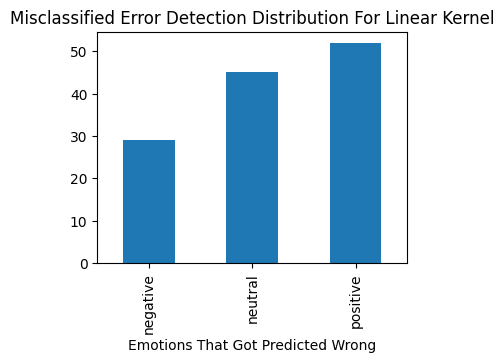

,text
emotion,
negative,29
neutral,45
positive,52


In [ ]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Linear Kernel")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()

# Experiment 2: RBF Kernel

## Training

In [ ]:
# Create SVM model with selected experiment kernel and train
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

# Do validation
y_valid_pred = svm_model.predict(X_valid)

## Evaluate training model

In [ ]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.8626984126984127
Precision: 0.8261217792587902
Recall: 0.8113463300356115
F1-Score: 0.8173553845799736
              precision    recall  f1-score   support

    negative       0.79      0.86      0.82       394
     neutral       0.77      0.68      0.72       131
    positive       0.92      0.90      0.91       735

    accuracy                           0.86      1260
   macro avg       0.83      0.81      0.82      1260
weighted avg       0.86      0.86      0.86      1260



In [ ]:
# Predict x column using SVM model
y_test_pred = svm_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.716
Test Precision: 0.7535806962558554
Test Recall: 0.647715846245258
Test F1-Score: 0.6575118575118576
Banyak data yang salah diprediksi: 142


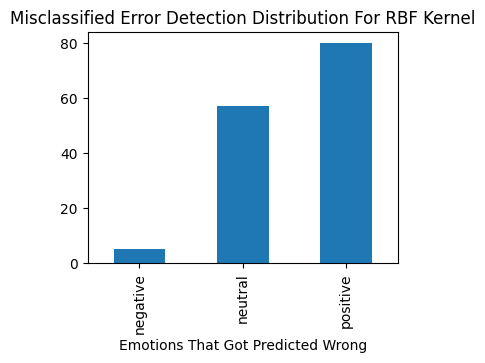

,text
emotion,
negative,5
neutral,57
positive,80


In [ ]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For RBF Kernel")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()

# Experiment 3: Poly Kernel

## Training

In [ ]:
# Create SVM model with selected experiment kernel and train
svm_model = SVC(kernel='poly')
svm_model.fit(X_train, y_train)

# Do validation
y_valid_pred = svm_model.predict(X_valid)

## Evaluate training model

In [ ]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.6888888888888889
Precision: 0.8137725230453375
Recall: 0.5382225568182867
F1-Score: 0.48604732658293215
              precision    recall  f1-score   support

    negative       0.50      0.92      0.65       394
     neutral       1.00      0.01      0.02       131
    positive       0.94      0.69      0.79       735

    accuracy                           0.69      1260
   macro avg       0.81      0.54      0.49      1260
weighted avg       0.81      0.69      0.67      1260



In [ ]:
# Predict x column using SVM model
y_test_pred = svm_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.446
Test Precision: 0.40591063279400635
Test Recall: 0.3636563599798894
Test F1-Score: 0.26222847319893733
Banyak data yang salah diprediksi: 277


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


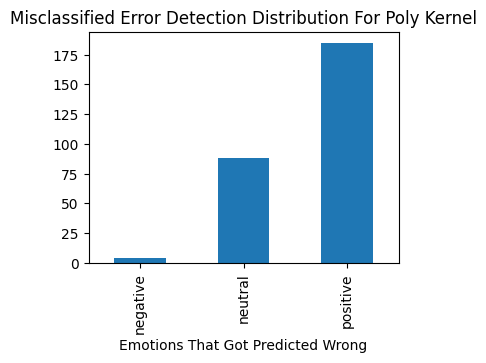

,text
emotion,
negative,4
neutral,88
positive,185


In [ ]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Poly Kernel")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()

# Experiment 4: Hyperparameter tuning

In [ ]:
# Do hyperparameter tuning
parameters = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]}
# Use grid search
grid_search = GridSearchCV(SVC(), parameters, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')

Best Parameters: {'C': 0.1, 'kernel': 'linear'}


## Training

In [ ]:
# Create SVM model with selected experiment kernel and train
svm_model = SVC(kernel='linear', C=0.1)
svm_model.fit(X_train, y_train)

# Do validation
y_valid_pred = svm_model.predict(X_valid)

## Evaluate training model

In [ ]:
def class_report_valid(y_valid, y_valid_pred):
  # Evaluate using metrics
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1-Score: {f1}')

  # Print classification report
  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy_test = accuracy_score(y_test, y_test_pred)
  precision_test = precision_score(y_test, y_test_pred, average='macro')
  recall_test = recall_score(y_test, y_test_pred, average='macro')
  f1_test = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy: {accuracy_test}')
  print(f'Test Precision: {precision_test}')
  print(f'Test Recall: {recall_test}')
  print(f'Test F1-Score: {f1_test}')

In [ ]:
# Evaluate on validation set
class_report_valid(y_valid, y_valid_pred)

Accuracy: 0.8722222222222222
Precision: 0.8372207413654905
Recall: 0.8424087595281456
F1-Score: 0.8385912160620334
              precision    recall  f1-score   support

    negative       0.79      0.89      0.84       394
     neutral       0.78      0.76      0.77       131
    positive       0.94      0.89      0.91       735

    accuracy                           0.87      1260
   macro avg       0.84      0.84      0.84      1260
weighted avg       0.88      0.87      0.87      1260



In [ ]:
# Predict x column using SVM model
y_test_pred = svm_model.predict(X_test)

# Evaluate on test set
class_report_test(y_test, y_test_pred)

# Error analysis: Print misclassified examples
df_test_unmasked['predicted_emotion'] = y_test_pred
misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]
misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
print(f'Banyak data yang salah diprediksi: {misclassified_count}')

Test Accuracy: 0.766
Test Precision: 0.7839388081310202
Test Recall: 0.7051681978152566
Test F1-Score: 0.7193318171024644
Banyak data yang salah diprediksi: 117


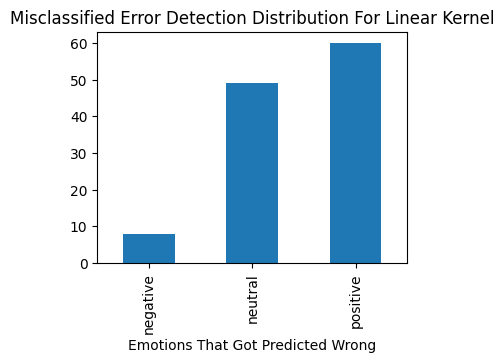

,text
emotion,
negative,8
neutral,49
positive,60


In [ ]:
misclassified_2 = misclassified.copy()

emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
misclassified_2['emotion'] = misclassified_2['emotion'].replace(emotion_decoding)
misclassified_2['predicted_emotion'] = misclassified_2['predicted_emotion'].replace(emotion_decoding)

fig = plt.figure(figsize=(4,3))
misclassified_2.groupby('emotion').text.count().plot.bar(ylim=0)
plt.title("Misclassified Error Detection Distribution For Linear Kernel")
plt.xlabel('Emotions That Got Predicted Wrong')
plt.show()
misclassified_2.groupby('emotion').text.count()